In [1]:
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt
from fbprophet import Prophet

In [2]:
def get_changepoints(df, algorithm, plot=False):
    
    if algorithm == 'Pelt':
        '''Returns all changepoints detected by PELT with penalty=5'''
        points = rpt.Pelt(model='rbf').fit_predict(df, pen=5)
        points = points[:-1]
        print("Predicted by {}:\n{}".format(algorithm, points))
    
    if algorithm == 'Prophet All':
        '''Returns all changepoints detected by Prophet in default tune'''
        prophet = df.copy().reset_index()
        prophet.columns = (['ds', 'y'])
        m = Prophet().fit(prophet)
        points = list(m.changepoints.index)
        print("Predicted by {}:\n{}".format(algorithm, points))
    
    if algorithm == 'Prophet Significant':
        '''Returns changepoints detected by Prophet in default tune
        with a rate change magnitude > the mean rate change magnitude'''
        prophet = df.copy().reset_index()
        prophet.columns = (['ds', 'y'])
        m = Prophet().fit(prophet)
        temp_df = pd.DataFrame({
            'point': m.changepoints.index,
            'delta': m.params['delta'].mean(0)
            })
        
        # extracting significant changepoints happens here
        delta_mean = np.mean(abs(temp_df.delta))
        points = []
        
        for i, row in temp_df.iterrows():
            if temp_df.delta[i] >= delta_mean:
                points.append(row.point)
            elif temp_df.delta[i] <= -delta_mean:
                points.append(row.point)
        points = list(map(int, points))
        print("Predicted by {}:\n{}".format(algorithm, points))
        
    if algorithm == 'Combined':
        '''Returns all PELT and significant Prophet changepoints'''      
        # PELT
        points = rpt.Pelt(model='rbf').fit_predict(df, pen=5)
        points = points[:-1]
        
        # Prophet
        prophet = df.copy().reset_index()
        prophet.columns = (['ds', 'y'])
        m = Prophet().fit(prophet)
        temp_df = pd.DataFrame({
            'point': m.changepoints.index,
            'delta': m.params['delta'].mean(0)
            })
        
        # extracting significant changepoints happens here
        delta_mean = np.mean(abs(temp_df.delta))
        points_prophet = []
        
        for i, row in temp_df.iterrows():
            if temp_df.delta[i] >= delta_mean:
                points_prophet.append(row.point)
            elif temp_df.delta[i] <= -delta_mean:
                points_prophet.append(row.point)
        
        for point in points_prophet:
            if point not in points:
                points.append(point)
        points = list(map(int, points))
        points.sort()
        print("Predicted by {}:\n{}".format(algorithm, points))
        
    if plot == True:
        %matplotlib inline
        sns.set_style('whitegrid')
        colors = sns.color_palette('deep', 8)
        sns.set_palette(colors)
        
        fig, ax = plt.subplots(figsize=(17,6), dpi=200)
        ax.plot(
            df.index.values,
            df[df.columns[0]],
            color=colors[0]
        )
        for pt in points:
            ax.axvline(
                x=df.index.values[int(pt)],
                color=colors[2],
                linewidth=1.5,
                linestyle='dashed'
            )
        ax.set_title(
            "Changepoints detected by {} algorithm".format(algorithm),
            size=16
            
        )
        ax.set_ylabel("USD", size=12)
        ax.set_xlabel("Date", size=12)
        plt.show()
        
    return points

In [3]:
raw = pd.read_json('df.json', orient='split')
ts = pd.DataFrame(raw.eth_close.copy())
ts.head()

,eth_close
2015-08-06,3.00
2015-08-07,1.20
2015-08-08,1.20
2015-08-09,1.20
2015-08-10,0.99


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicted by Combined:
[525, 563, 630, 660, 788, 825, 835, 860, 880, 900, 910, 950, 985, 1040, 1100]


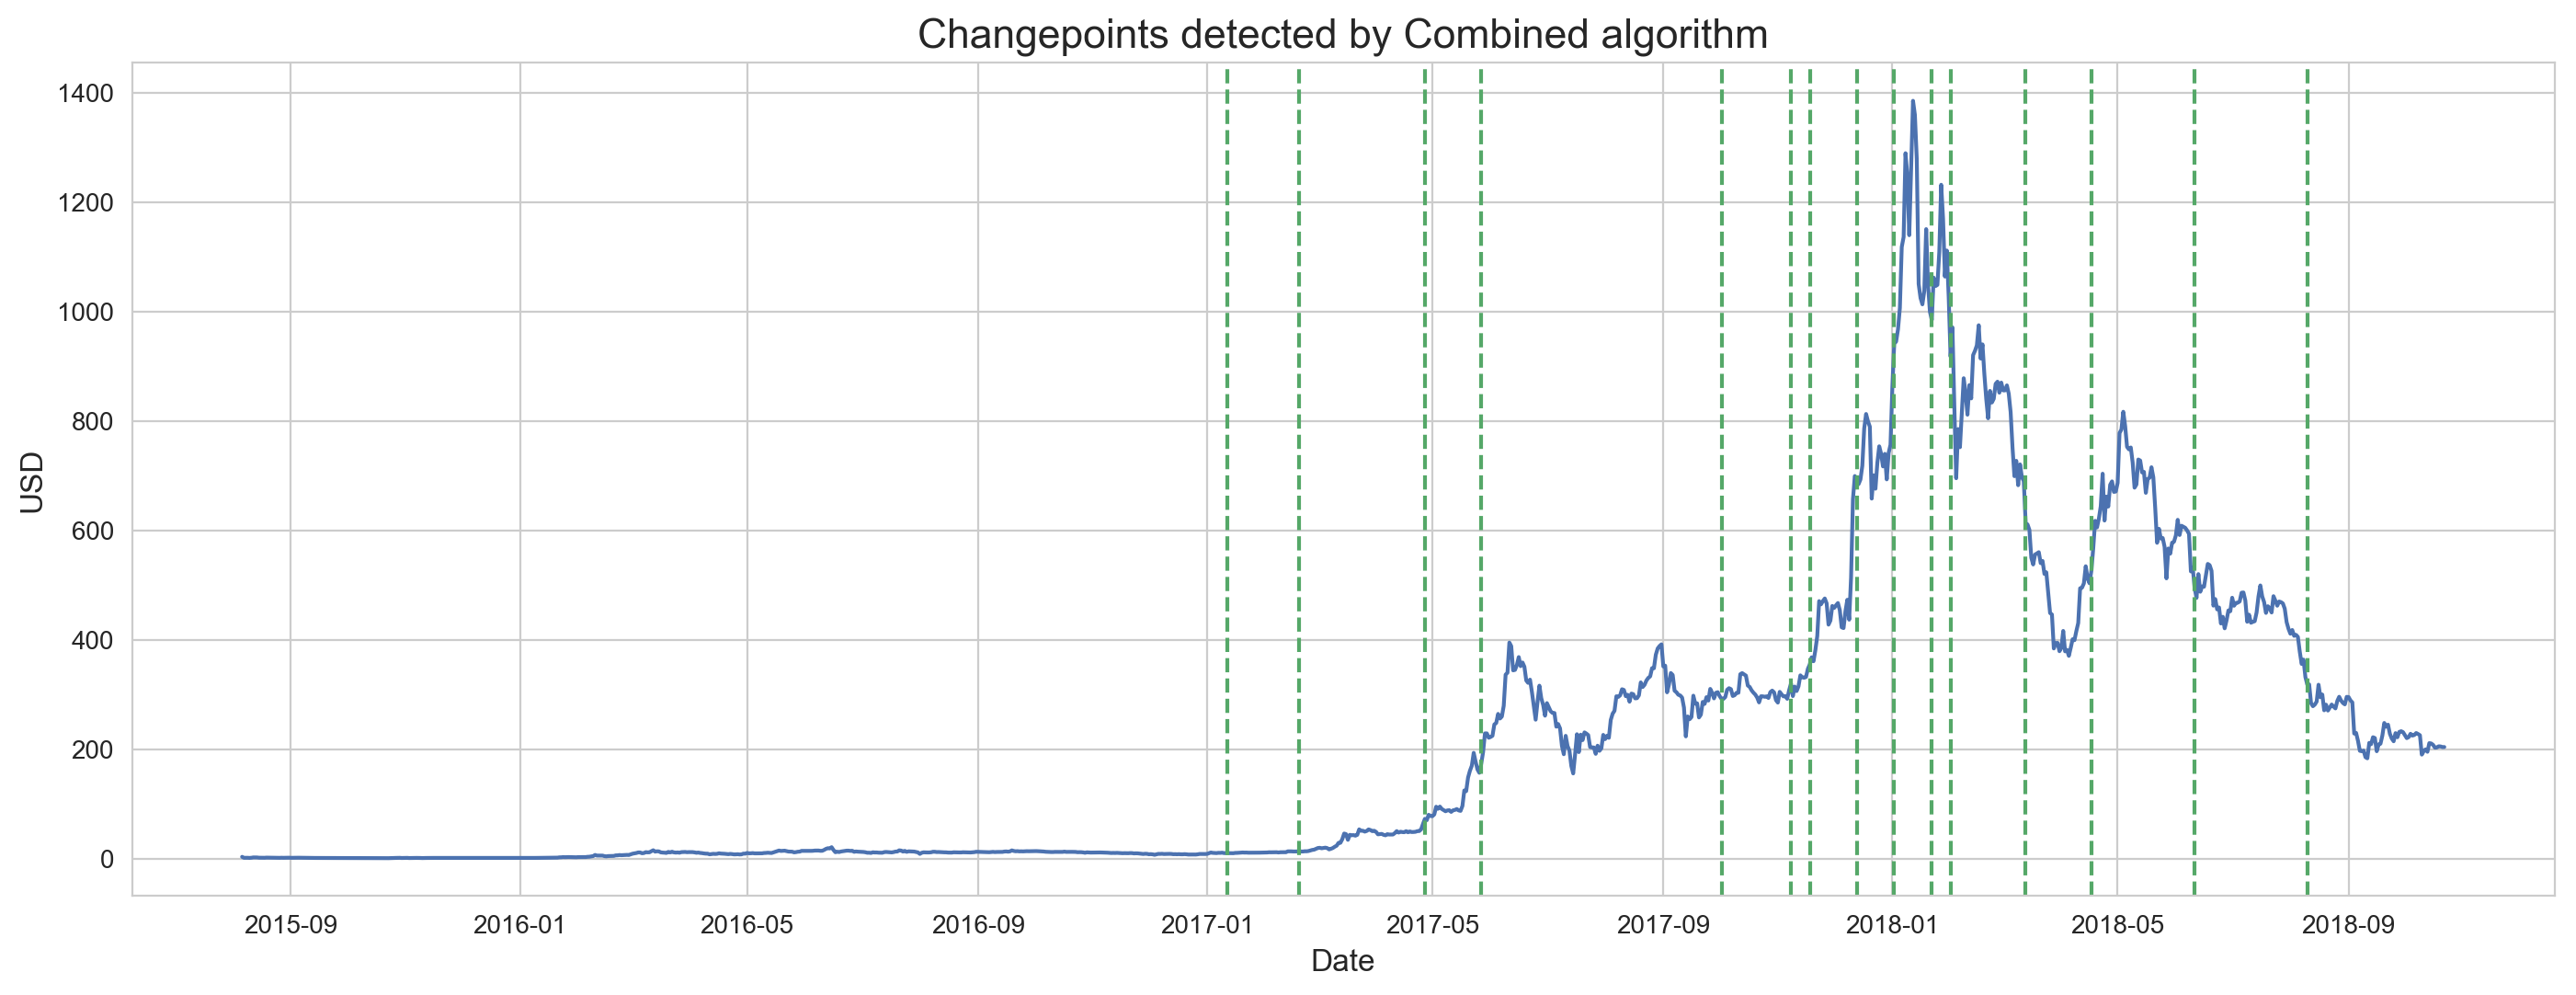

In [4]:
cpts = get_changepoints(df=ts, algorithm='Combined', plot=True)